# Plotting strain rates with GPS
This is assuming the strain rates have been established. Using rates derived June 28 after shifting profiles and accounting for surface distortions.

In [1]:
# Load libraries
import sys
import sys
sys.path.append("../../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import pickle

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress
from scipy.signal import detrend
from helpers import *

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    22:51:02 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    22:51:02 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    22:51:02 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


In [2]:
# Load data
ds_11 = reload("A101")
ds_11 = ds_11.isel(time=range(20,len(ds_11.time))) # trim first few bursts, which were tests

ds_13 = reload("A103_fixed")
ds_13 = ds_13.isel(time=range(60,len(ds_13.time))) # trim first few bursts, which were tests

ds_14 = reload("A104")
ds_14 = ds_14.isel(time=range(50,len(ds_14.time))) # trim first few bursts, which were tests



In [3]:
# helper functions
def shift_profile_range(profiles,shift_value):
    profiles_adjust = profiles.where(profiles.profile_range > shift_value, drop = True)
    profiles_adjust['profile_range'] = profiles_adjust.profile_range - shift_value
    return profiles_adjust

def strain_metrics(ds, win_cor, step, lag, noise_floor,bin_adjust=1):
    # This function, given a window, and step, gives a total percentage of data that has high coherence
    b1 = ds.isel(time=range(0,len(ds)-lag))
    b2 = ds.isel(time=range(lag,len(ds)))
    dz, co, phi = xa.generate_range_diff(b1,b2,win_cor,step,None,0,0.95)
    dz=dz.assign(coherence=(['time','profile_range'],co))
    dz_new = dz.where(abs(dz.coherence) > 0.95).drop_duplicates('time')

    vv = dz_new.range_diff / dz_new.time_diff * 31536000
    vv_adjust = vv - vv.isel(profile_range = range(0,bin_adjust)).mean(dim='profile_range')
    vv_err = dz_new.err / dz_new.time_diff * 31536000
    vv_mean_err = (vv_err.isel(profile_range = range(0,bin_adjust))**2).sum(dim='profile_range')/bin_adjust
    vv_adjust_err = np.sqrt(vv_err**2 + vv_mean_err)

    #fit=vv.where(vv.profile_range <=noise_floor).polyfit('profile_range',1,full=True)
    fit=vv.where(vv.profile_range <=noise_floor).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv.where(vv.profile_range <=noise_floor)-vv.where(vv.profile_range <=noise_floor).mean())**2).sum(dim='profile_range')
    
    slope = fit.polyfit_coefficients.sel(degree=1)*vv.profile_range+fit.polyfit_coefficients.sel(degree=0)
    residual = vv-slope
    residual = residual.where(residual.profile_range <=noise_floor,drop=True)
    slope_errs = np.sqrt((1/(len(residual.profile_range)-2))*(((residual**2).sum(dim='profile_range'))/((residual.profile_range - residual.profile_range.mean())**2).sum()))

    int_err = slope_errs*np.sqrt(((vv.profile_range)**2).sum()/len(vv.profile_range))
    ds = vv.to_dataset(name='vv')
    ds['err'] = vv_err
    ds['slope']= fit.polyfit_coefficients.sel(degree=1)
    ds['intercept']=fit.polyfit_coefficients.sel(degree=0)
    ds['fit'] = slope
    ds['slope_err'] = slope_errs
    ds['int_err'] = int_err
    ds['vv_adjust'] = vv_adjust
    ds['vv_adjust_err'] = vv_adjust_err
    ds['doy_decimal'] =  ds.time.dt.dayofyear + (ds.time.dt.hour / 24) + (ds.time.dt.minute / 1440) + (ds.time.dt.second / 86400)
    return ds

def convert_to_doy(da):
    da['doy_decimal'] = da.time.dt.dayofyear + (da.time.dt.hour / 24) + (da.time.dt.minute / 1440) + (da.time.dt.second / 86400)
    return da

In [4]:
# get strain rate timeseries
#A11
ds_11_drain = ds_11.isel(time=range(4200,5200))
test = custom_profile(ds_11_drain.isel(attenuator_setting_pair=0).chirp,clip_threshold=1.2,min_chirps = 5,start=20000)
time_to_interp = pd.date_range("2022-07-09 12:00", "2022-07-19 12:00", freq="15min")
interp_profiles = test.interp(time=time_to_interp,method='linear')
interp_profiles['doy_decimal'] = interp_profiles.time.dt.dayofyear + (interp_profiles.time.dt.hour / 24) + (interp_profiles.time.dt.minute / 1440) + (interp_profiles.time.dt.second / 86400)
interp_profiles_adjust = shift_profile_range(interp_profiles,35)
a11 = strain_metrics(interp_profiles, 50, 50,1,500)
a11_adjust = strain_metrics(interp_profiles_adjust, 50, 50,1,500,2)

#A13
ds_13_drain = ds_13.isel(time=range(4200,5200))
test = custom_profile(ds_13_drain.isel(attenuator_setting_pair=0).chirp,clip_threshold=1.2,min_chirps = 5,start=30000)
time_to_interp = pd.date_range("2022-07-09 12:00", "2022-07-19 12:00", freq="15min")
interp_profiles = test.interp(time=time_to_interp,method='linear')
interp_profiles['doy_decimal'] = interp_profiles.time.dt.dayofyear + (interp_profiles.time.dt.hour / 24) + (interp_profiles.time.dt.minute / 1440) + (interp_profiles.time.dt.second / 86400)
interp_profiles_adjust = shift_profile_range(interp_profiles,25)
a13 = strain_metrics(interp_profiles, 24, 24,1,500)
a13_adjust = strain_metrics(interp_profiles_adjust, 24, 24,1,500,1)

#A14
ds_14_drain = ds_14.isel(time=range(4200,5200))
test = custom_profile(ds_14_drain.isel(attenuator_setting_pair=0).chirp,clip_threshold=1.2,min_chirps = 5,start=4000)
time_to_interp = pd.date_range("2022-07-09 12:00", "2022-07-19 12:00", freq="15min")
interp_profiles = test.interp(time=time_to_interp,method='linear')
interp_profiles['doy_decimal'] = interp_profiles.time.dt.dayofyear + (interp_profiles.time.dt.hour / 24) + (interp_profiles.time.dt.minute / 1440) + (interp_profiles.time.dt.second / 86400)
interp_profiles_adjust = shift_profile_range(interp_profiles,35)
a14 = strain_metrics(interp_profiles, 80, 80,1,500)
a14_adjust = strain_metrics(interp_profiles_adjust, 80, 80,1,500,1)


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom
/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value e

In [5]:
# load gps
# SQ11
colnames = ['Time','East','North','Up','sigma_east','sigma_north','sigma_up']
data = pd.read_csv('sq11_YY_MM_DD_HR_MIN_SEC.txt', sep=" ", names=colnames, header=None)
#data['datetime']=  pd.to_datetime(
#                      data['Time'], unit='D', origin=pd.Timestamp('2021-12-31')
#                      )

data = data.set_index('Time')
data = data.assign(East_detrend=detrend(data.East))

sq11 = data.to_xarray()

#SQ13
data = pd.read_csv('sq13_YY_MM_DD_HR_MIN_SEC.txt', sep=" ", names=colnames, header=None)
#data['datetime']=  pd.to_datetime(
#                      data['Time'], unit='D', origin=pd.Timestamp('2021-12-31')
#                      )

data = data.set_index('Time')
data = data.assign(East_detrend=detrend(data.East))

sq13 = data.to_xarray()

#SQ14
data = pd.read_csv('sq14_YY_MM_DD_HR_MIN_SEC.txt', sep=" ", names=colnames, header=None)
#data['datetime']=  pd.to_datetime(
#                      data['Time'], unit='D', origin=pd.Timestamp('2021-12-31')
#                      )

data = data.set_index('Time')
data = data.assign(East_detrend=detrend(data.East))

sq14 = data.to_xarray()

In [6]:
sq11

<xarray.Dataset> Size: 4MB
Dimensions:       (Time: 57598)
Coordinates:
  * Time          (Time) float64 461kB 190.0 190.0 190.0 ... 200.0 200.0 200.0
Data variables:
    East          (Time) float64 461kB 0.0 0.0016 0.0044 ... -4.675 -4.686
    North         (Time) float64 461kB 0.0 -0.0036 -0.0004 ... 0.4355 0.4446
    Up            (Time) float64 461kB 0.0 0.0059 0.0125 ... 0.2676 0.3064
    sigma_east    (Time) float64 461kB 0.016 0.016 0.016 ... 0.015 0.015 0.015
    sigma_north   (Time) float64 461kB 0.0254 0.0254 0.0253 ... 0.0176 0.0176
    sigma_up      (Time) float64 461kB 0.0633 0.0631 0.063 ... 0.04 0.0399
    East_detrend  (Time) float64 461kB -0.1372 -0.1355 ... 0.08235 0.07174

Text(0.5, 1.0, 'SQ14/A14')

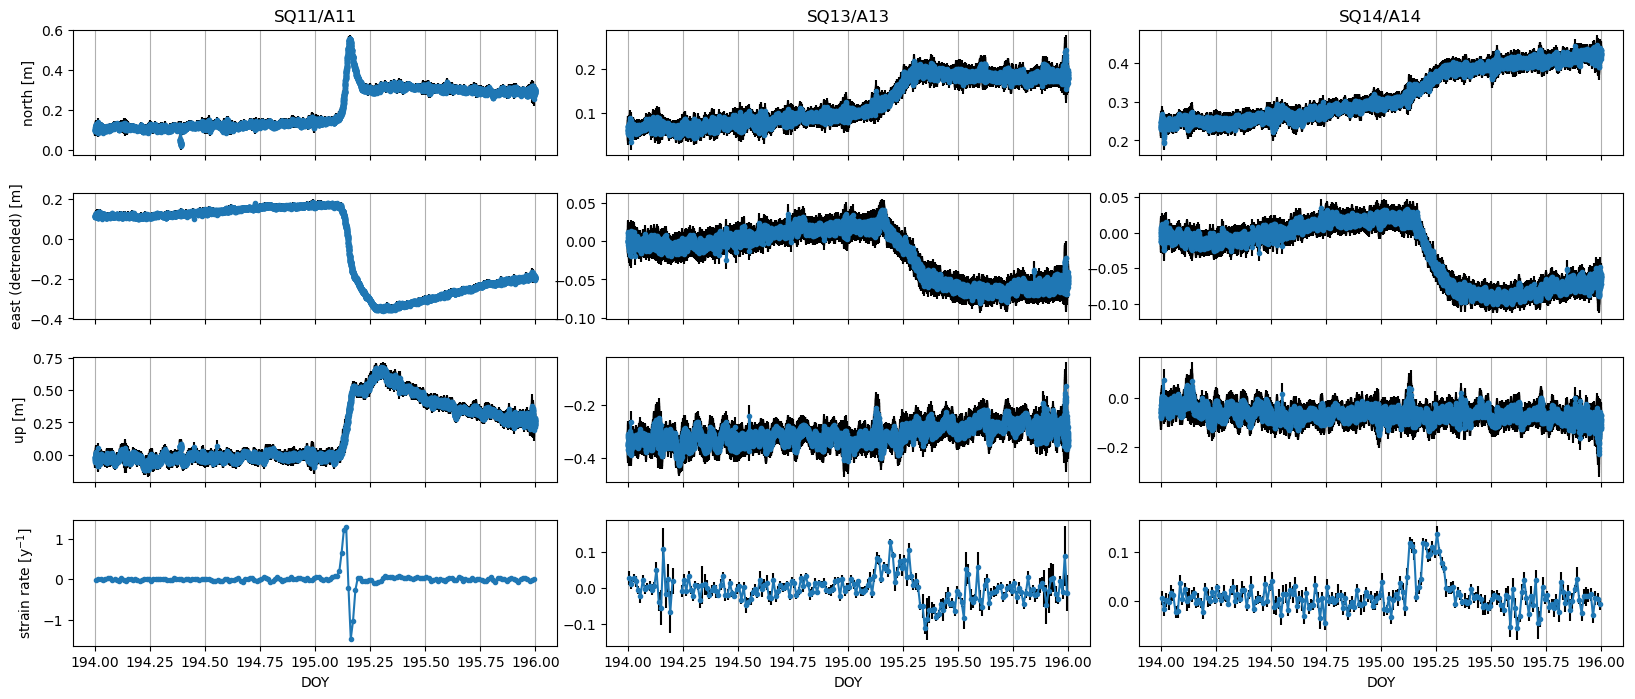

In [7]:
fig, axs = plt.subplots(nrows= 4, ncols = 3, sharex=True,figsize = (20,8))

doy_range = [194,196] # max pretty much 191 to 200
for ds,ds_adjust,i in zip([a11,a13,a14],[a11_adjust,a13_adjust,a14_adjust],[0,1,2]):
    ds = ds.where(ds.doy_decimal > doy_range[0]).where(ds.doy_decimal < doy_range[1])
    ds_adjust = ds_adjust.where(ds_adjust.doy_decimal > doy_range[0]).where(ds_adjust.doy_decimal < doy_range[1])
    #axs[3][i].errorbar(ds.doy_decimal,ds.slope,yerr=ds.slope_err,marker='.',ecolor='k',label = 'No profile_range correction')
    axs[3][i].errorbar(ds_adjust.doy_decimal,ds_adjust.slope,yerr=ds_adjust.slope_err,marker='.',ecolor='k',label = 'With shifted range')
    axs[3][i].set_xlabel('DOY')
    axs[3][i].grid(axis = 'x')

for ds, i in zip([sq11,sq13,sq14],[0,1,2]):
    ds = ds.where(ds.Time > doy_range[0]).where(ds.Time < doy_range[1])
    axs[0][i].errorbar(ds.Time,ds.North,yerr=ds.sigma_north,marker='.',ecolor='k',)
    axs[1][i].errorbar(ds.Time,ds.East_detrend,yerr=ds.sigma_east,marker='.',ecolor='k',)
    axs[2][i].errorbar(ds.Time,ds.Up,yerr=ds.sigma_up,marker='.',ecolor='k',)

    axs[0][i].grid(axis = 'x')
    axs[1][i].grid(axis = 'x')
    axs[2][i].grid(axis = 'x')

# Clean up things here
plt.subplots_adjust(hspace=0.3,wspace=0.1)
axs[3][0].set_ylabel('strain rate [y$^{-1}$]')
axs[2][0].set_ylabel('up [m]')
axs[1][0].set_ylabel('east (detrended) [m]')
axs[0][0].set_ylabel('north [m]')

axs[0][0].set_title('SQ11/A11')
axs[0][1].set_title('SQ13/A13')
axs[0][2].set_title('SQ14/A14')